# Clustering pe dataset-ul Weightlifting

În acest notebook vom aplica mai multe metode de clustering pe un set de date de antrenamente („sessions”) înregistrate în `weightlifting_721_workouts.csv`. Vom extrage caracteristici numerice pentru fiecare sesiune și apoi vom folosi:
- K-Means
- Clustering ierarhic (Agglomerative + dendrogramă)
- DBSCAN
- OPTICS
- Gaussian Mixture Model
- Spectral Clustering

Pentru fiecare metodă vom afișa:
1. Print cu numărul de elemente în fiecare cluster
2. Scatter plot în 2D (după reducerea dimensionalității cu PCA) colorat după eticheta de cluster


In [37]:
# 1. incarcare si preprocesare date
import pandas as pd

# incarca dataset-ul
df = pd.read_csv('../DataSet/weightlifting_721_workouts.csv')

# Definim fiecare sesiune prin combinatia Date + Workout Name
df['session_id'] = df['Date'].astype(str) + ' | ' + df['Workout Name']

# Calculam caracteristici pentru fiecare sesiune
session_features = df.groupby('session_id').agg(
    total_volume = ('Weight', lambda x: (x * df.loc[x.index, 'Reps']).sum()),
    total_reps   = ('Reps', 'sum'),
    avg_weight   = ('Weight', 'mean'),
    num_exercises= ('Exercise Name', 'nunique')
).reset_index()

session_features.head()

,session_id,total_volume,total_reps,avg_weight,num_exercises
0,2015-10-23 17:06:37 | Chest,37940.0,168,222.272727,3
1,2015-10-23 22:01:34 | Squat 1,51360.0,180,273.750000,6
2,2015-10-24 10:19:52 | Back,24760.0,240,101.730769,6
3,2015-10-30 13:07:09 | Chest,31930.0,154,202.272727,3
4,2015-10-30 17:47:44 | Back,27010.0,264,102.142857,6


In [38]:
# 2. Standardizare si PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['total_volume', 'total_reps', 'avg_weight', 'num_exercises']
X = session_features[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Adaugam coordonate PCA pentru ploturi
session_features['PCA1'] = X_pca[:,0]
session_features['PCA2'] = X_pca[:,1]


K-Means cluster counts:
0    201
1    262
2    120
Name: count, dtype: int64


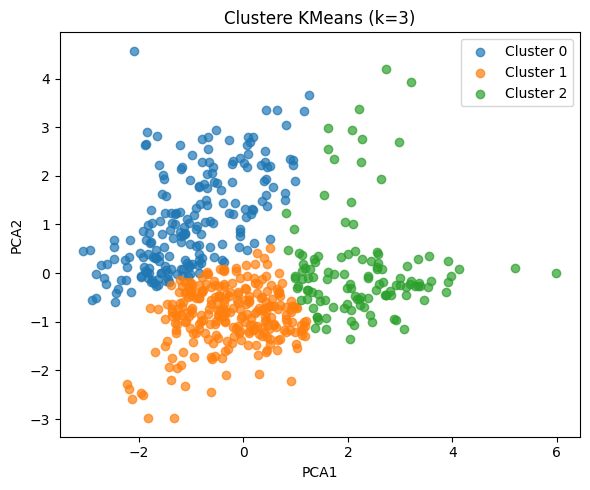

In [39]:
# 3. K-Means clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
session_features['km_label'] = labels_km

# Print distributie
print("K-Means cluster counts:")
print(pd.Series(labels_km).value_counts().sort_index())

# Plot
plt.figure(figsize=(6,5))
for lbl in sorted(set(labels_km)):
    mask = labels_km == lbl
    plt.scatter(session_features.loc[mask, 'PCA1'], session_features.loc[mask, 'PCA2'], label=f'Cluster {lbl}', alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustere KMeans (k=3)')
plt.legend()
plt.tight_layout()
plt.show()


### 3.1. Centrele clusterelor K-Means (Centroids)
Afișăm centrele clusterelor (centroids) suprapuse peste scatter-ul PCA pentru K-Means.

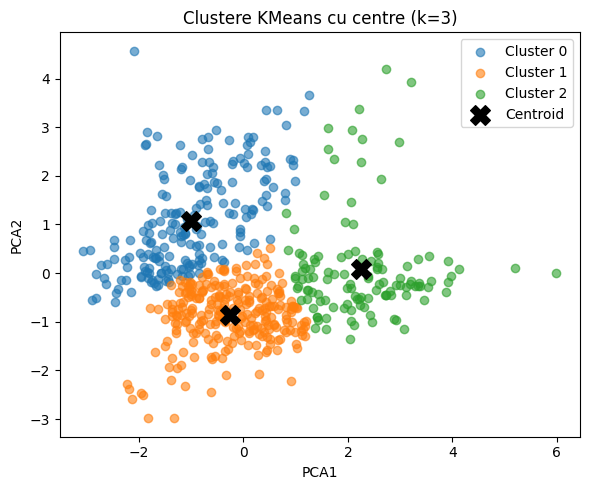

In [40]:
# Afisare centroida K-Means pe scatter PCA
import matplotlib.pyplot as plt
import numpy as np

# Proiectam centrele in spatiul PCA
centroids_scaled = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids_scaled)

plt.figure(figsize=(6,5))
# Scatter-ul original
for lbl in sorted(set(labels_km)):
    mask = (labels_km == lbl)
    plt.scatter(session_features.loc[mask, 'PCA1'],
                session_features.loc[mask, 'PCA2'],
                label=f'Cluster {lbl}', alpha=0.6)
# Adaugam centroids
plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
            marker='X', s=200, c='black', label='Centroid')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustere KMeans cu centre (k=3)')
plt.legend()
plt.tight_layout()
plt.show()

### 3.2. Profil mediu al caracteristicilor pe fiecare cluster
Vizualizăm valorile medii ale fiecărei caracteristici pentru fiecare cluster K-Means.

<Figure size 800x400 with 0 Axes>

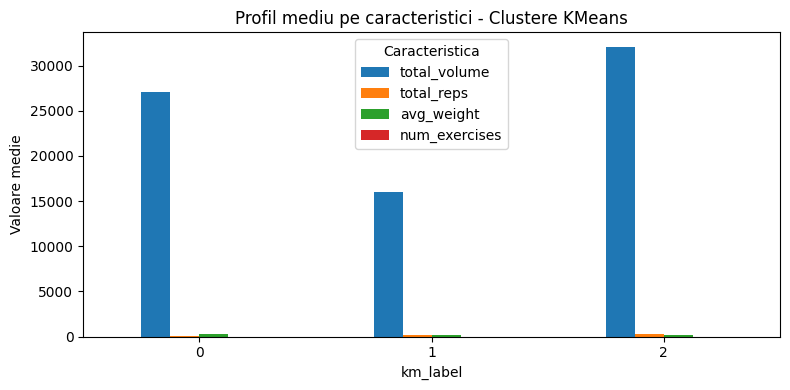

In [41]:
# Profil mediu pe caracteristici pentru fiecare cluster
cluster_means = session_features.groupby('km_label')[
    ['total_volume','total_reps','avg_weight','num_exercises']
].mean()

plt.figure(figsize=(8,4))
cluster_means.plot(kind='bar', figsize=(8,4))
plt.title('Profil mediu pe caracteristici - Clustere KMeans')
plt.ylabel('Valoare medie')
plt.xticks(rotation=0)
plt.legend(title='Caracteristica')
plt.tight_layout()
plt.show()

### 3.3. Parallel Coordinates pentru clusterele K-Means
Folosim Parallel Coordinates pentru a compara direct distribuțiile caracteristicilor între clustere.

d:\PYTHON-Folder\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


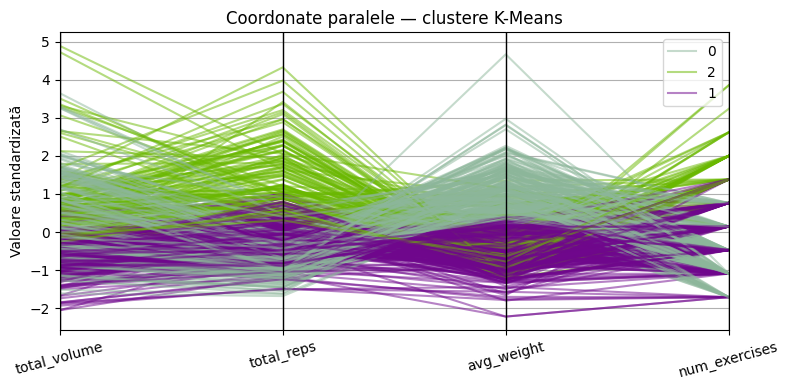

In [ ]:
# ---------------- Parallel Coordinates corect ----------------
from pandas.plotting import parallel_coordinates

# 1. selectam DOAR variabilele numerice relevante + eticheta
features = ['total_volume', 'total_reps', 'avg_weight', 'num_exercises']
pc_df = session_features[['km_label'] + features].copy()

# 2. standardizam variabilele numerice (fara a atinge km_label)
pc_df[features] = scaler.transform(pc_df[features])

# 3. asiguram etichetele de tip string
pc_df['km_label'] = pc_df['km_label'].astype(str)

# 4. plot
plt.figure(figsize=(8,4))
parallel_coordinates(pc_df, 'km_label', alpha=0.5)
plt.title('Coordonate paralele — clustere K-Means')
plt.ylabel('Valoare standardizata')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Fiecare linie reprezintă o sesiune de antrenament, colorată după clusterul K-Means (0, 1 sau 2).

Pe axele de la stânga spre dreapta avem valorile pentru:

- `total_volume` (volum total)
- `total_reps` (număr total repetări)    
- `avg_weight` (greutate medie)
- `num_exercises` (număr de exerciții)

-------------------------------------------------------------------------------------------------------------------------------------------------

- `Clusterul 2` (verde) are, în general, cele mai mari volume și puține repetări → probabil sportive care lucrează cu greutăți mari, puține seturi.
- `Clusterul 1` (mov) are volume mici și multe repetări → antrenamente de enduranță, mai multe seturi cu greutăți mai mici.
- `Clusterul 0` (verde deschis) stă undeva la mijloc: volume moderate, repetări moderate, mai echilibrat.

Agglomerative cluster counts:
0    219
1    130
2    234
Name: count, dtype: int64


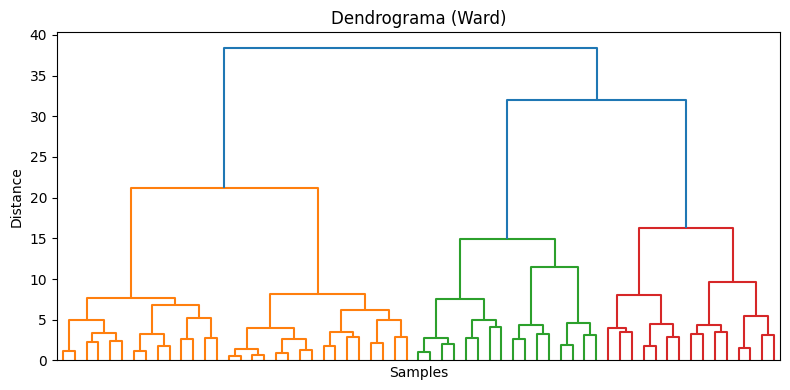

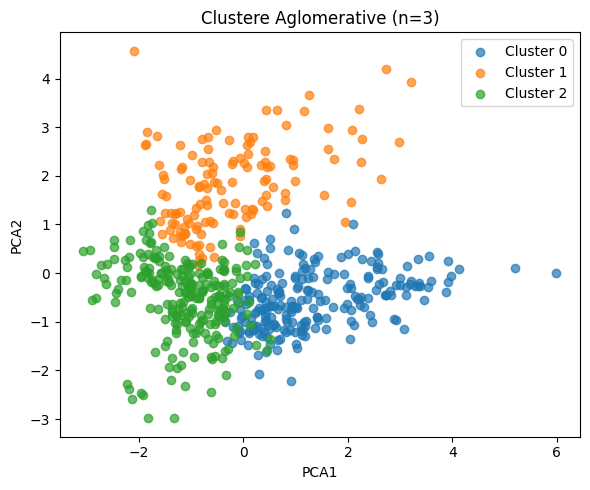

In [49]:
# 4. Clustering ierarhic (Agglomerative) si dendrograma
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

# Agglomerative clustering
agg = AgglomerativeClustering(n_clusters=3)
labels_agg = agg.fit_predict(X_scaled)
session_features['agg_label'] = labels_agg

print("Agglomerative cluster counts:")
print(pd.Series(labels_agg).value_counts().sort_index())

# Dendrogram
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode='level', p=5, no_labels=True)
plt.title('Dendrograma (Ward)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Scatter
plt.figure(figsize=(6,5))
for lbl in sorted(set(labels_agg)):
    mask = labels_agg == lbl
    plt.scatter(session_features.loc[mask, 'PCA1'], session_features.loc[mask, 'PCA2'], label=f'Cluster {lbl}', alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustere Aglomerative (n=3)')
plt.legend()
plt.tight_layout()
plt.show()


DBSCAN cluster counts (incl. -1 noise):
-1      94
 0       5
 1      26
 2      72
 3       5
 4      98
 5     138
 6      79
 7      16
 8      18
 9       7
 10      5
 11     10
 12      5
 13      5
Name: count, dtype: int64


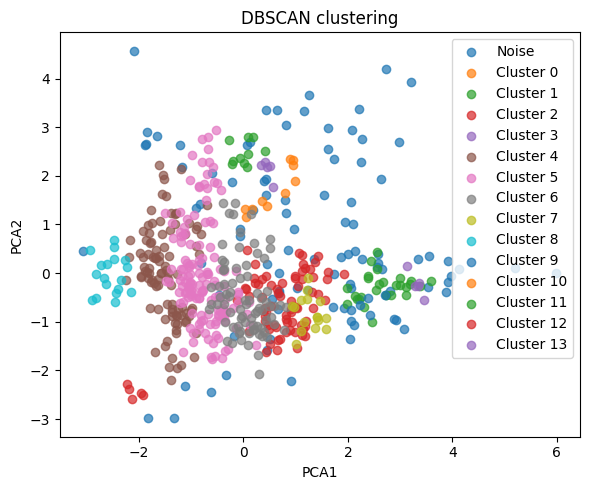

In [50]:
# 5. DBSCAN clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(X_scaled)
session_features['db_label'] = labels_db

print("DBSCAN cluster counts (incl. -1 noise):")
print(pd.Series(labels_db).value_counts().sort_index())

plt.figure(figsize=(6,5))
unique_labels = sorted(set(labels_db))
for lbl in unique_labels:
    mask = labels_db == lbl
    label_name = 'Noise' if lbl == -1 else f'Cluster {lbl}'
    plt.scatter(session_features.loc[mask, 'PCA1'], session_features.loc[mask, 'PCA2'], label=label_name, alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('DBSCAN clustering')
plt.legend()
plt.tight_layout()
plt.show()


- DBSCAN a găsit multe grupuri locale și un număr semnificativ de sesiuni considerate zgomot.

Ce am observat:
- Sesiunile „normale” (cele trei mari grupuri) apar tot în jurul punctelor centrale, dar DBSCAN găsește și sub-clustere pe baza densității locale.
- Zgomotul reprezintă sesiuni anormale (outlieri) care nu se încadrează în niciun grup dens.

OPTICS cluster counts (incl. -1 noise):
-1    218
 0     73
 1    118
 2     74
 3    100
Name: count, dtype: int64


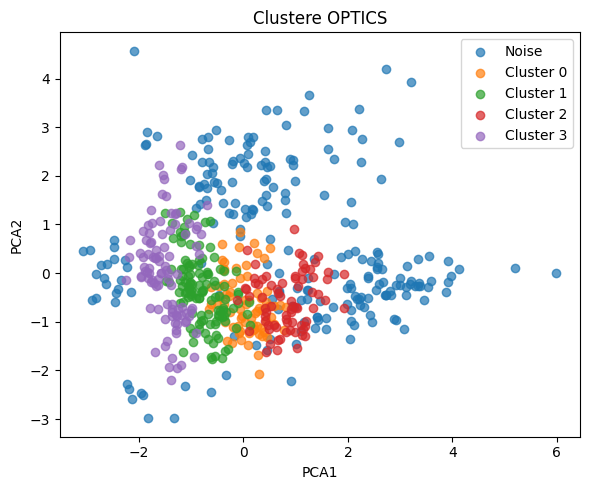

In [51]:

from sklearn.cluster import OPTICS

opt = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
labels_opt = opt.fit_predict(X_scaled)
session_features['opt_label'] = labels_opt

print("OPTICS cluster counts (incl. -1 noise):")
print(pd.Series(labels_opt).value_counts().sort_index())

plt.figure(figsize=(6,5))
for lbl in sorted(set(labels_opt)):
    mask = labels_opt == lbl
    name = 'Noise' if lbl == -1 else f'Cluster {lbl}'
    plt.scatter(session_features.loc[mask, 'PCA1'], session_features.loc[mask, 'PCA2'], label=name, alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustere OPTICS')
plt.legend()
plt.tight_layout()
plt.show()


GMM cluster counts:
0    206
1    265
2    112
Name: count, dtype: int64


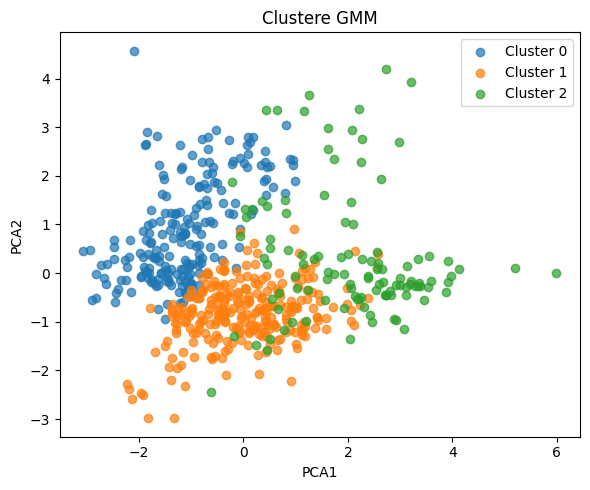

In [52]:
# 7. Gaussian Mixture Model clustering
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
session_features['gmm_label'] = labels_gmm

print("GMM cluster counts:")
print(pd.Series(labels_gmm).value_counts().sort_index())

plt.figure(figsize=(6,5))
for lbl in sorted(set(labels_gmm)):
    mask = labels_gmm == lbl
    plt.scatter(session_features.loc[mask, 'PCA1'], session_features.loc[mask, 'PCA2'], label=f'Cluster {lbl}', alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustere GMM')
plt.legend()
plt.tight_layout()
plt.show()


Spectral cluster counts:
0    263
1    229
2     91
Name: count, dtype: int64


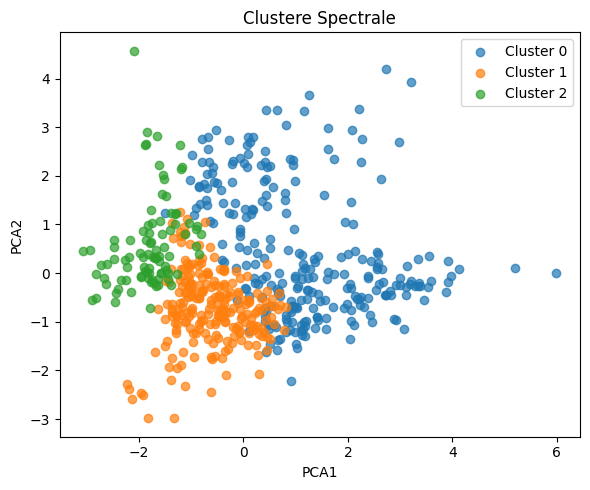

In [53]:
# 8. Spectral Clustering
from sklearn.cluster import SpectralClustering

spec = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels_spec = spec.fit_predict(X_scaled)
session_features['spec_label'] = labels_spec

print("Spectral cluster counts:")
print(pd.Series(labels_spec).value_counts().sort_index())

plt.figure(figsize=(6,5))
for lbl in sorted(set(labels_spec)):
    mask = labels_spec == lbl
    plt.scatter(session_features.loc[mask, 'PCA1'], session_features.loc[mask, 'PCA2'], label=f'Cluster {lbl}', alpha=0.7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustere Spectrale')
plt.legend()
plt.tight_layout()
plt.show()


## Concluzii generale

- **K-Means** oferă un bun punct de plecare, dar presupune k fix.
- **Clustering ierarhic** permite vizualizarea dendrogramei și alegerea dinamică a k.
- **DBSCAN** și **OPTICS** identifică zgomotul și nu necesită specificarea k, dar parametrii `eps` și `min_samples` influențează rezultatele.
- **GMM** oferă o abordare probabilistă (soft clustering), utilă când cluster-ele se suprapun.
- **Spectral Clustering** gestionează forme neconvexe și relații de similaritate complexe.

